In [1]:
import tensorflow as tf
import vgg
import cv2
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

In [2]:
vgg_weights, vgg_mean = vgg.load_net("imagenet-vgg-verydeep-19.mat")

In [18]:
# max is 224
def resize_aspect_ratio(image):
    height,width,_ = image.shape
    new_shape = [224,224]
    if height < width:
        scaling_factor = 224./width
        height = height * scaling_factor
        new_shape[1] = int(height)
    else:
        scaling_factor = 224./height
        width = width * scaling_factor
        new_shape[0] = int(width)
    image = cv2.resize(image, dsize = tuple(new_shape), interpolation=cv2.INTER_AREA)
    return image

In [4]:
content = cv2.resize(cv2.cvtColor(cv2.imread("ollie.jpg"),cv2.COLOR_BGR2RGB),dsize = (224,224), interpolation = cv2.INTER_AREA)
style = cv2.resize(cv2.cvtColor(cv2.imread("moses-1945.jpg"),cv2.COLOR_BGR2RGB),dsize = (224,224), interpolation = cv2.INTER_AREA)

In [25]:
content = cv2.cvtColor(cv2.imread("ollie.jpg"),cv2.COLOR_BGR2RGB)
style = cv2.cvtColor(cv2.imread("starry.jpg"),cv2.COLOR_BGR2RGB)

In [39]:
118-123.68

-5.680000000000007

In [43]:
vgg_mean.reshape(1,1,3)

array([[[ 123.68 ,  116.779,  103.939]]])

In [61]:
np.mean(content,axis = (0,1))

array([ 102.77995456,  114.71528221,  119.94124681])

In [62]:
np.mean(content[:,:,0])

102.77995455994898

In [4]:
content.shape

(224, 224, 3)

In [6]:
content_layers = ['relu4_2']
style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

### Content Representation

In [26]:
content_outputs = []
g = tf.Graph()
with g.as_default(), tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    image = tf.placeholder(tf.float32, shape=np.expand_dims(content,0).shape)
    net = vgg.net_preloaded(vgg_weights,image)
    for layer in content_layers:
        content_out = sess.run(net[layer],feed_dict = {image: [vgg.preprocess(content,vgg_mean)]})[0]
        content_outputs.append(content_out)
content_outputs = np.asarray(content_outputs)
tf.reset_default_graph()

In [9]:
content_outputs.shape

(1, 42, 34, 512)

In [27]:
style_outputs = []
g = tf.Graph()
with g.as_default(), tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    image = tf.placeholder(tf.float32, shape=np.expand_dims(style,0).shape)
    net = vgg.net_preloaded(vgg_weights,image)
    style_in = [vgg.preprocess(style,vgg_mean)]
    for layer in style_layers:
        out_ = sess.run(net[layer],{image:style_in})
        out_ = np.transpose(np.reshape(out_,(out_.shape[1]*out_.shape[2],out_.shape[3])))
        gram = np.matmul(out_,np.transpose(out_))/(out_.shape[1]*out_.shape[0]) # Gram is AA^T
        style_outputs.append(gram)
style_outputs = np.asarray(style_outputs)
tf.reset_default_graph()

### Style Representation

## Loss Function

In [28]:
image = tf.Variable(tf.random_normal(np.expand_dims(content,0).shape))
# image = tf.Variable(np.reshape(ok,(1,224,224,3)).astype('float32'))
# image = tf.Variable(np.asarray([vgg.preprocess(content,vgg_mean).astype(np.float32)]))
net = vgg.net_preloaded(vgg_weights,image)

### Content Loss

In [29]:
c_layer_loss = []
for i,layer in enumerate(content_layers):
    out_ = net[layer][0]
    c_layer_loss.append(tf.nn.l2_loss(content_outputs[i]-out_))
c_loss = reduce(tf.add,c_layer_loss)

### Style Loss

In [30]:
s_layer_loss = []
for i,layer in enumerate(style_layers):
    out_ = net[layer][0]
    out_ = tf.reshape(out_,[-1,int(out_.shape[2])])
    gram = tf.matmul(tf.transpose(out_),out_)/int(int(out_.shape[1])*int(out_.shape[0])) # Gram is AA^T
    s_layer_loss.append(tf.nn.l2_loss(gram-style_outputs[i])/2)
s_loss = reduce(tf.add,s_layer_loss)/float(len(s_layer_loss))

### Variation Loss

In [64]:
alpha = 5
beta = 3e4
w = 1e-3
tv = tf.image.total_variation(image)[0]
total_loss = alpha*c_loss + beta*s_loss + w*tv

In [65]:
optimizer = tf.train.AdamOptimizer(learning_rate = 10).minimize(total_loss)

In [66]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())
first = sess.run(image)[0]
iter_ = 1000
min_ = 1e20
best = None
for i in range(iter_):
    loss_,cl,sl,_,lol = sess.run([total_loss,c_loss,s_loss,optimizer,tv])
    if i%10 == 0:
        print("Iteration ", str(i), " | Loss: ",str(loss_), " | TV_loss: ", str(lol), " | Content_loss: ",cl, " | Style_loss: ",sl)
    if loss_<min_:
        best = sess.run(image)
        min_ = loss_

Iteration  0  | Loss:  7.06828e+12  | TV_loss:  599513.0  | Content_loss:  1.76056e+10  | Style_loss:  2.32675e+08
Iteration  10  | Loss:  1.20077e+12  | TV_loss:  1.28992e+07  | Content_loss:  3.28705e+10  | Style_loss:  3.45472e+07
Iteration  20  | Loss:  5.33845e+11  | TV_loss:  1.55512e+07  | Content_loss:  3.33597e+10  | Style_loss:  1.22349e+07
Iteration  30  | Loss:  3.4013e+11  | TV_loss:  1.52277e+07  | Content_loss:  3.26236e+10  | Style_loss:  5.9004e+06
Iteration  40  | Loss:  2.55895e+11  | TV_loss:  1.43241e+07  | Content_loss:  3.17086e+10  | Style_loss:  3.24505e+06
Iteration  50  | Loss:  2.14913e+11  | TV_loss:  1.3653e+07  | Content_loss:  3.01485e+10  | Style_loss:  2.13903e+06
Iteration  60  | Loss:  1.90492e+11  | TV_loss:  1.32805e+07  | Content_loss:  2.86094e+10  | Style_loss:  1.5815e+06
Iteration  70  | Loss:  1.74202e+11  | TV_loss:  1.30781e+07  | Content_loss:  2.72726e+10  | Style_loss:  1.26129e+06
Iteration  80  | Loss:  1.62717e+11  | TV_loss:  1.29446

Iteration  700  | Loss:  9.03391e+10  | TV_loss:  1.31906e+07  | Content_loss:  1.56256e+10  | Style_loss:  407040.0
Iteration  710  | Loss:  9.14607e+10  | TV_loss:  1.3178e+07  | Content_loss:  1.53917e+10  | Style_loss:  483409.0
Iteration  720  | Loss:  8.88992e+10  | TV_loss:  1.31908e+07  | Content_loss:  1.55604e+10  | Style_loss:  369898.0
Iteration  730  | Loss:  8.87331e+10  | TV_loss:  1.31898e+07  | Content_loss:  1.55557e+10  | Style_loss:  365156.0
Iteration  740  | Loss:  8.95509e+10  | TV_loss:  1.31769e+07  | Content_loss:  1.5371e+10  | Style_loss:  423204.0
Iteration  750  | Loss:  9.2789e+10  | TV_loss:  1.32068e+07  | Content_loss:  1.56422e+10  | Style_loss:  485928.0
Iteration  760  | Loss:  1.01167e+11  | TV_loss:  1.33072e+07  | Content_loss:  1.61105e+10  | Style_loss:  687141.0
Iteration  770  | Loss:  1.37865e+11  | TV_loss:  1.35432e+07  | Content_loss:  1.6809e+10  | Style_loss:  1.794e+06
Iteration  780  | Loss:  1.76726e+11  | TV_loss:  1.40865e+07  | Co

In [67]:
print(min_)

8.76417e+10


In [68]:
lol = best[0]

In [69]:
ok = np.clip(vgg.unprocess(lol,vgg_mean,1),0,255).astype('uint8')

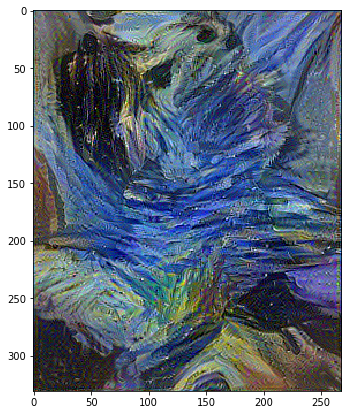

In [70]:
plt.imshow(ok)
plt.show()

In [85]:
x,y,z = ok[:,:,0].flatten(),ok[:,:,1].flatten(),ok[:,:,2].flatten()

In [86]:
from mpl_toolkits.mplot3d import Axes3D

In [22]:
plt.rcParams['figure.figsize'] = (7, 7)

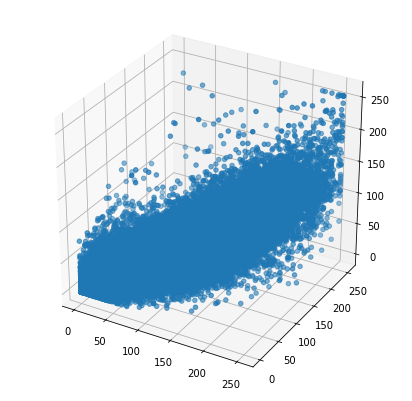

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(x,y,z)
plt.show()

In [71]:
cv2.imwrite("ollie.png",cv2.cvtColor(ok,cv2.COLOR_RGB2BGR))

True

In [ ]:
plt.imshow(vgg.unprocess(vgg.preprocess(content,vgg_mean),vgg_mean,1).astype(np.uint8))
plt.show()

In [ ]:
cv2.cvtColor(cv2.imread("ollie.jpg"),cv2.COLOR_BGR2RGB).astype(float).shape

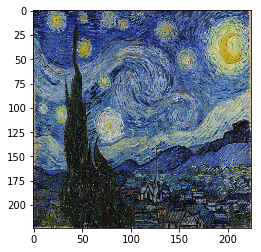

In [51]:
plt.imshow(np.reshape(np.reshape(style,(224*224,-1)),(224,224,-1)))
plt.show()

In [ ]:
content.shape

In [56]:
style_outputs[1]

array([[  5.14978930e+00,   1.09179034e+00,   1.20842761e-02, ...,
          6.48402498e+00,   3.50258590e+00,   1.75026687e+00],
       [  1.09179034e+00,   7.12225267e+01,   1.71341690e+01, ...,
          9.97257254e+01,   5.78442333e+01,   3.49519018e+01],
       [  1.20842761e-02,   1.71341690e+01,   8.38889609e+01, ...,
          9.18424446e+01,   1.17187002e+01,   4.44828852e+01],
       ..., 
       [  6.48402498e+00,   9.97257254e+01,   9.18424446e+01, ...,
          5.40620137e+02,   1.60416165e+02,   1.51255082e+02],
       [  3.50258590e+00,   5.78442333e+01,   1.17187002e+01, ...,
          1.60416165e+02,   1.56439294e+02,   3.38638767e+01],
       [  1.75026687e+00,   3.49519018e+01,   4.44828852e+01, ...,
          1.51255082e+02,   3.38638767e+01,   1.65568001e+02]])